In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

pd.options.display.precision = 2 # reduce the defalt display precision to two decimals (this doesn't affect the actual numbers used, only prints?)

# Read in ICA blinks for merged raws from all subjects

In [2]:
eog_peaks = {}
fs_Hz = 64.0

for subjectID in range(1, 21+1):
    npy_path = f'../../data/eog_peaks/merged_raws/eog_peaks_sub{subjectID}_merged_raws.npy'
    arr = np.load(npy_path, allow_pickle=True)
    arr = arr.flat[0]
    eog_peaks[subjectID] = arr[subjectID]


Helper functions to extract relevant info from imported npy ICA data:

In [3]:
# Convert dt object to float seconds
def dtToSeconds(row):
    return row.minute * 60.0 + row.second + (row.microsecond / 1e6)

def descToCondition(row):
    if 'Listening' in row:
        condition = 'Listening' 
    else:
        condition = 'Imagery'
    return condition

def descToChorale(row):
    return row.split('-')[-1]

# Count number of blinks
def countBlinks(subjectID, onset_s, duration, eog_peaks, fs_Hz = 64.0):
    trial_end_s = onset_s + duration
    
    ica_eog_events = np.float64(eog_peaks[subjectID]['ica_eog_events'])
    #print(ica_eog_events)
    ica_eog_events /= fs_Hz
    
    num_blinks = sum((onset_s < ica_eog_events) & (ica_eog_events < trial_end_s))
    return num_blinks

In [4]:
df_all = pd.DataFrame()

for subjectID in eog_peaks:
    # Convert MNE annotations for start/duration time stamp of each trial to a dataframe
    df = eog_peaks[subjectID]['trial_annots'].to_data_frame()

    # Add subjectID as a column (for when we concat all subject dataframes)
    df['subjectID'] = subjectID

    # Drop annotations from merging rawArrays for each trial
    df = df[(df['description'] != 'BAD boundary') & (df['description'] != 'EDGE boundary')]

    # Add trial index as a column
    df['trial'] = range(88)

    # Only retain the time from datetime objects for 'onset'
    df['onset_s'] = df['onset'].apply(
        dtToSeconds
    )

    df['blinks'] = df.apply(
        lambda x: countBlinks(x['subjectID'], x['onset_s'], x['duration'], eog_peaks, fs_Hz), 
        axis = 1,
    )

    df_all = pd.concat([df_all, df])

# Reset row indices so they now count up from 0 to 87 (88 trials total)
df_all.reset_index(
    inplace=True, # modify df indices in place
    drop=True, # do not add a new index column
)

df_all['condition'] = df_all['description'].apply(
    descToCondition,
)

df_all['chorale'] = df_all['description'].apply(
    descToChorale,
)

# Rename "description" (from annotations) to "condition"
# df_all = df_all.rename(columns={"description": "condition"})
df_all

,onset,duration,description,subjectID,trial,onset_s,blinks,condition,chorale
0,1970-01-01 00:00:00.000000,28.16,Listening/chor-096,1,0,0.00,10,Listening,096
1,1970-01-01 00:00:28.171875,28.16,Listening/chor-096,1,1,28.17,5,Listening,096
2,1970-01-01 00:00:56.343750,28.16,Listening/chor-038,1,2,56.34,8,Listening,038
3,1970-01-01 00:01:24.515625,28.16,Listening/chor-038,1,3,84.52,8,Listening,038
4,1970-01-01 00:01:52.687500,28.16,Listening/chor-101,1,4,112.69,4,Listening,101
...,...,...,...,...,...,...,...,...,...
1843,1970-01-01 00:38:58.265625,28.16,Imagery/chor-096,21,83,2338.27,1,Imagery,096
1844,1970-01-01 00:39:26.437500,28.16,Imagery/chor-038,21,84,2366.44,3,Imagery,038
1845,1970-01-01 00:39:54.609375,28.16,Imagery/chor-038,21,85,2394.61,3,Imagery,038
1846,1970-01-01 00:40:22.781250,28.16,Imagery/chor-019,21,86,2422.78,1,Imagery,019


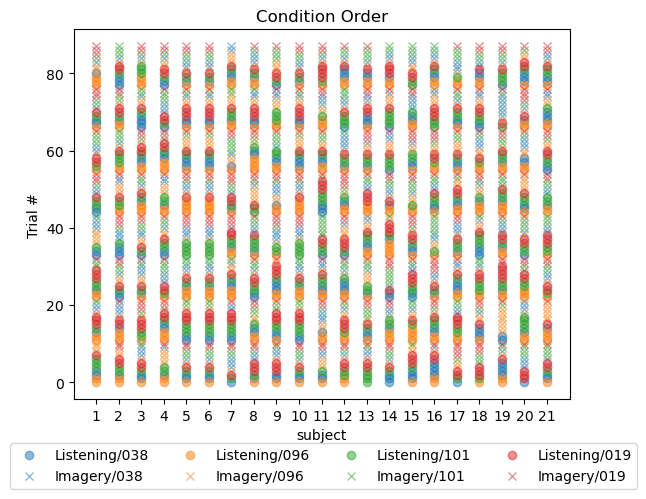

In [5]:
fig, ax = plt.subplots()

ch_x_offset = 0
for chorale in ['038', '096', '101', '019']:
    df = df_all[(df_all['condition'] == 'Listening') & (df_all['chorale'] == chorale)]
    line, = ax.plot(
        df['subjectID'] + (1/8)*ch_x_offset,
        df['trial'],
        marker = 'o',
        ls = '',
        label = f'Listening/{chorale}',
        alpha=0.5,
    )

    df = df_all[(df_all['condition'] == 'Imagery') & (df_all['chorale'] == chorale)]
    ax.plot(
        df['subjectID'] + (2/8)*ch_x_offset,
        df['trial'],
        marker = 'x',
        ls = '',
        c = line.get_color(),
        label = f'Imagery/{chorale}',
        alpha=0.5,
    )

    ch_x_offset += 0 #1

plt.xticks(
    ticks = range(1, 21+1)
)
plt.title('Condition Order')
plt.xlabel('subject')
plt.ylabel('Trial #')
plt.legend(bbox_to_anchor=(1.15, -0.1), ncols = 4)
plt.show()

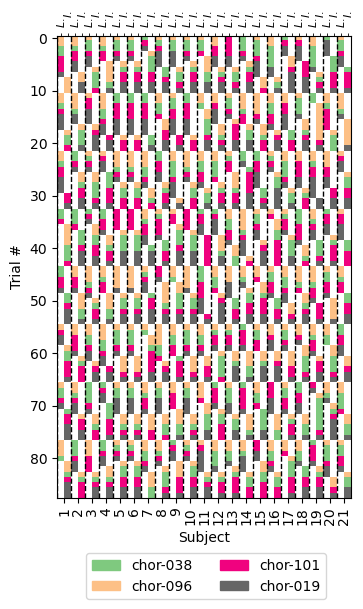

In [221]:
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 6))

# https://stackoverflow.com/a/26693107
design_matrix = np.nan * np.ones(shape=(21*2, 88)) # make nan so unused pixels can be colored using set_bad below
chorales = {
    0: '038',
    1: '096',
    2: '101',
    3: '019',
}
conditions = {
    0: 'Listening',
    1: 'Imagery'
}

i = 0
for subjectID in range(21):
    for condID in range(2):
        for chorID in range(4):
            chorale = chorales[chorID]
            condition = conditions[condID]
            df = df_all[
                (df_all['subjectID'] == subjectID+1) &
                (df_all['condition'] == condition) & 
                (df_all['chorale'] == chorale)
                ]
            #print(i, chorID, condID, subjectID+1, condition, chorale)
            #print(df)
            trial_idxs = np.array(df['trial'])
            #print(trial_idxs)
            design_matrix[i, trial_idxs] = chorID
        i += 1 # update to track condition

cmap = plt.cm.Accent
cmap.set_bad((0, 0, 0, 0))

im = ax.imshow(
    design_matrix.T, 
    cmap = cmap, 
    interpolation=None,
    aspect = .75,
    #norm = None,
    #vmin = 0,
    #vmax = 1,
    filternorm = False,
)

# get the colors of the values, according to the 
# colormap used by imshow
values = range(4)
colors = [im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [] #mpatches.Patch(color=(1, 1, 1, 1)) for i in range(1)]
patches.extend([mpatches.Patch(color=colors[i], label=f'chor-{chorales[i]}') for i in range(len(values))])

# put those patched as legend-handles into the legend
plt.legend(
    handles=patches, 
    bbox_to_anchor=(.1, -.12), 
    ncols = 2,
    loc=2, 
    borderaxespad=0. )

for x in range(21):
    ax.axvline(
        x=2*x -0.5,
        c = 'k',
        linewidth = 1,
        ls = '--',
    )

plt.xticks(
    ticks = np.arange(0.5, 42, 2),
    labels = range(1, 21+1),
    rotation = 90,
)
plt.xticks(
    ticks = np.arange(0, 42, 1),
    labels = ['$L.$', '   $I.$']*21,
    rotation = 90,
    minor=True,
    fontsize = 8,
)
plt.tick_params(axis='x', 
                which='minor', 
                top=True, 
                labeltop = True,
                bottom=False,
                labelbottom = False,
                )
plt.xlabel('Subject')
plt.ylabel('Trial #')
plt.show()

In [176]:
dir(im)

['_A',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_axes',
 '_callbacks',
 '_check_unsampled_image',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_default_contains',
 '_extent',
 '_filternorm',
 '_filterrad',
 '_fully_clipped_to_axes',
 '_get_scalar_alpha',
 '_gid',
 '_id_norm',
 '_imcache',
 '_in_layout',
 '_internal_update',
 '_interpolation',
 '_interpolation_stage',
 '_label',
 '_make_image',
 '_mouseover',
 '_norm',
 '_path_effects',
 '_picker',
 '_rasterized',
 '_remove_method',
 '_resample',
 '_scale_norm',
 '_set_alpha_for_array',
 '_set_gc_clip',
 '_sketch',
 '_snap',
 

# Pivot Table To Get Mean / Median Blink Counts
By condition (description) and subject

In [ ]:
df_pivot = pd.pivot_table(
    df_all,
    values = 'blinks',
    index = 'subjectID',
    columns = ['condition', 'chorale'],
    aggfunc = ['mean', 'median', 'sum']
)

df_pivot

In [ ]:
# Sort subjectIDs by sum of blinks
conds_in_asc_blink_sum = df_pivot['sum'].sum(axis=0).sort_values().index
conds_in_asc_blink_sum

In [ ]:
subjectIDs_in_asc_blink_sum = df_pivot['sum'].sum(axis=1).sort_values().index
subjectIDs_in_asc_blink_sum

In [ ]:
df_pivot['mean'][conds_in_asc_blink_sum]

In [ ]:
df_pivot['mean'].loc[subjectIDs_in_asc_blink_sum, conds_in_asc_blink_sum]

In [ ]:
stim_order = [
    ('Listening', '038'),
    ('Listening', '096'),
    ('Listening', '101'),
    ('Listening', '019'), 
    ('Imagery', '038'), 
    ('Imagery', '096'),
    ('Imagery', '101'), 
    ('Imagery', '019'), 
]

In [ ]:
df_pivot['mean'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='bwr',
    axis = 1,
).set_properties() #**{'font-size': '20px'}) 
# https://www.geeksforgeeks.org/display-the-pandas-dataframe-in-heatmap-style/ 

In [ ]:
print(df_pivot['median'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='bwr',
    axis = 1,
).to_latex(
        convert_css = True,
        column_format="r|c|c|c|c|c|c|c|c|",
        #hrules = True,
        clines = 'all;data',
        #multicol_align = {'c'},
    )
)

df_pivot['median'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='bwr',
    axis = 1,
)

In [ ]:
print(df_pivot['sum'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='magma',
    axis = 1,
).to_latex(
    convert_css = True,
    column_format="r|c|c|c|c|c|c|c|c|",
    #hrules = True,
    clines = 'all;data',
    #multicol_align = {'c'},
    )
)

df_pivot['sum'].loc[subjectIDs_in_asc_blink_sum, stim_order].style.background_gradient(
    cmap ='magma',
    axis = 1,
)

In [ ]:
df_pivot['median'][stim_order]

In [ ]:
df_pivot.index

# Normalize each trial's blink count 
using subjects' avg. blink count over all trials 

In [ ]:
def normBlinks(subjectID, blinks, df_all, numTrials = 88):
    blinkSum = df_all[df_all['subjectID'] == subjectID]['blinks'].sum()
    return blinks / (blinkSum / numTrials) # now this is just scaling the subject's avg. blink rate

df_all['blinks_norm'] = df_all.apply(
    lambda x: normBlinks(x['subjectID'], x['blinks'], df_all, 88),
    axis = 1,
)

In [ ]:
df_all

In [ ]:
df_pivot_norm = pd.pivot_table(
    df_all,
    values = 'blinks_norm',
    index = 'subjectID',
    columns = ['condition', 'chorale'],
    aggfunc = ['mean', 'median', 'sum']
)

df_pivot_norm

In [ ]:
method = 'mean'
cmap = 'bwr'
vmin = 0
vmax = 2
precision = 1

print(df_pivot_norm[method].loc[subjectIDs_in_asc_blink_sum, stim_order].style.set_precision(precision).background_gradient(
    cmap = cmap,
    vmin = vmin,
    vmax= 2,
    #axis = 1,
).to_latex(
        convert_css = True,
        column_format="r|c|c|c|c|c|c|c|c|",
        #hrules = True,
        clines = 'all;data',
        #multicol_align = {'c'},
    )
)

df_pivot_norm[method].loc[subjectIDs_in_asc_blink_sum, stim_order].style.set_precision(precision).background_gradient(
    cmap =cmap,
    vmin = vmin,
    vmax= vmax,
    #axis = 1,
)

In [ ]:
stim_order_stack = [
    ('Listening', '038'),
    ('Imagery', '038'), 
    ('Listening', '096'),
    ('Imagery', '096'),
    ('Listening', '101'),
    ('Imagery', '101'), 
    ('Listening', '019'), 
    ('Imagery', '019'), 
]

fig, ax = plt.subplots(figsize = (4,4))

x = np.zeros_like(df_pivot_norm['mean'][stim_order[0]])
c = {}
for stim in stim_order_stack:
    y = range(1, 21+1)
    del_x = df_pivot_norm['mean'].loc[subjectIDs_in_asc_blink_sum, stim]

    condition = stim[0]
    chorale = stim[1]
    if condition == 'Listening':
        marker = '.'
        alpha = 0.7
    elif condition == 'Imagery':
        marker = '.'
        alpha = 0.3
        
    if chorale in c:
        line, = plt.plot(
            x + del_x,
            y,
            marker=marker,
            c = c[chorale],
        )
    else:
        line, = plt.plot(
            x + del_x,
            y,
            marker=marker,
        )
        c[chorale] = line.get_color()

    plt.fill_betweenx(
        y,
        x,
        x + del_x,
        color = c[chorale],
        alpha = alpha,
        label = stim,
    )
    
    x += del_x

plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)
#plt.xticks(rotation=90)
plt.yticks(
    ticks = range(1, 21+1),
    labels= subjectIDs_in_asc_blink_sum, #x, #range(1, 21+1),
    #rotation = 90,
)
#plt.yscale('log')
plt.xlabel('Blink Modulation x Conditions')
plt.ylabel('Subject')
ax.invert_yaxis()
plt.show()

In [ ]:
fig, ax = plt.subplots()

for name, group in df_all.groupby(['condition']):
    group.plot(
        x = 'subjectID',
        y = 'blinks',
        marker = '.',
        ls = '-',
        ax = ax,
        alpha = 0.5,
        label = name,
    )
plt.xticks(
    ticks = range(1, 21+1),
    labels= range(1, 21+1),
)

plt.show()

In [ ]:
fig, ax = plt.subplots()

for name, group in df_all.groupby(['condition']):
    group.plot(
        x = 'subjectID',
        y = 'blinks_norm',
        marker = '.',
        ls = '',
        ax = ax,
        alpha = 0.5,
        label = name,
        logy = True,
    )

#plt.ylim([0, 10])
plt.xticks(
    ticks = range(1, 21+1),
    labels= range(1, 21+1),
)

plt.show()

In [ ]:
import seaborn as sb

# https://www.tutorialspoint.com/python-pandas-draw-vertical-bar-plots-with-nested-grouping-by-two-categorical-variables-in-seaborn


fig, ax = plt.subplots(figsize=(15, 5))

sb.barplot(
    x = df_all['condition'],
    y = df_all['blinks_norm'],
    hue = 'subjectID',
    data = df_all,
    ax = ax,
    #stacked = True,
)

ax.set_ylim([0, 5])

# Appendix

In [ ]:
# Taking in the subject data, each condition (see map) is the key for a
# blink value that is the number of blinks in the duration of the trial
npy_path = 'Subject1BlinksData.npy'
arr = np.load(npy_path, allow_pickle=True)
arr = arr.flat[0]

In [ ]:
# Numerical map for each of the song and listening or imagining conditions
Listeningchor96_Indexes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Imaginingchor96_Indexes = [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]

Listeningchor38_Indexes = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Imaginingchor38_Indexes = [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

Listeningchor101_Indexes = [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
Imaginingchor101_Indexes = [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]

Listeningchor19_Indexes = [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Imaginingchor19_Indexes = [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87]

chors = [Listeningchor19_Indexes,Listeningchor38_Indexes,Listeningchor96_Indexes,Listeningchor101_Indexes,
         Imaginingchor19_Indexes,Imaginingchor38_Indexes,Imaginingchor96_Indexes,Imaginingchor101_Indexes]

In [ ]:
# Creating 2D array with rows equal to the number of chors and conditions and cols equal to test number
ConditionArray = np.empty([len(chors),len(chors[1])], dtype=int)

# Filling 2D ndarray with blink info row corresponds to L/I + chor##
# and col is the number of blinks in one of the 11 trials
rowi = 0
for chorindexes in chors:

    coli = 0
    for key in chorindexes:
        ConditionArray[rowi, coli] = arr[key]
        coli += 1

    rowi += 1


# Running statistical analysis with student's t. Comparing each condition to all others
# Array for storing the tstatistic and pval results as a list with [tstat, pval]
StatArray_t = np.empty([8,8], dtype = list)
StatArray_p = np.empty([8,8], dtype = list)

# Conducting two-tailed t test as the null hypothesis is that there is difference between the distributions
# Each distribution will be compared against all other distributions, including itself
rowi = 0
for Row in ConditionArray:
    for trialIdx in range(len(Row)):
        if trialIdx == 0:
            alpha = 1
            trial, = plt.plot(
                rowi, Row[trialIdx], 
                '.', 
                alpha = alpha, #1-trialIdx/len(Row)
            )
        else:
            alpha = 1-trialIdx/len(Row)
            plt.plot(
                rowi, Row[trialIdx], 
                '.', 
                alpha = alpha,
                c=trial.get_color(),
            )
    plt.plot(rowi, np.mean(Row), 'x', c=trial.get_color())

    coli = 0
    for Col in ConditionArray:

        t_statistic, p_value = ttest_ind(Row, Col)
        
        StatArray_t[rowi, coli] = t_statistic
        StatArray_p[rowi, coli] = p_value
        coli += 1

    rowi += 1


# print(StatArray)


# Converting StatArray to a dataframe for easy analysis

df_t = pd.DataFrame(StatArray_t)
df_p = pd.DataFrame(StatArray_p)

chors = [Listeningchor19_Indexes,Listeningchor38_Indexes,Listeningchor96_Indexes,Listeningchor101_Indexes,
         Imaginingchor19_Indexes,Imaginingchor38_Indexes,Imaginingchor96_Indexes,Imaginingchor101_Indexes]

plt.xticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    rotation='vertical'
)
plt.ylabel('#Blinks')
plt.title(npy_path)
plt.show()

# Rename columns and rows for easy analysis
for df in [df_t, df_p]:
    df.rename(columns={0: 'Listeningchor19', 1: 'Listeningchor38', 2: 'Listeningchor96', 3: 'Listeningchor101',
                    4: 'Imaginingchor19', 5: 'Imaginingchor38', 6: 'Imaginingchor96', 7: 'Imaginingchor101'}, inplace=True)

    df.rename(index={0: 'Listeningchor19', 1: 'Listeningchor38', 2: 'Listeningchor96', 3: 'Listeningchor101',
                    4: 'Imaginingchor19', 5: 'Imaginingchor38', 6: 'Imaginingchor96', 7: 'Imaginingchor101'}, inplace=True)


    #print(df)

In [ ]:
df_t

In [ ]:
df_p

In [ ]:
plt.imshow(np.array(df_p < 0.05))
plt.xticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    rotation='vertical'
)
plt.yticks(
    ticks=range(rowi), 
    labels=['Listeningchor19', 'Listeningchor38', 'Listeningchor96', 'Listeningchor101',
            'Imaginingchor19', 'Imaginingchor38', 'Imaginingchor96', 'Imaginingchor101'],
    #rotation='vertical'
)
plt.show()